# Notebook for testing clustering by ocr results including locations

In [28]:
import sys
import cv2
import numpy as np
import pandas as pd

sys.path.insert(0, "../")
from db import HindsightDB
import utils
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

In [2]:
db = HindsightDB()

In [3]:
frames = db.get_frames(impute_applications=False)
frames = utils.add_datetimes(frames)
frames = frames.sort_values(by='datetime_local', ascending=False)

In [4]:
df = frames.loc[frames['application'] == 'Whatsapp']

In [5]:
len(df)

3180

In [16]:
ocr_res = db.get_frames_with_ocr(frame_ids=set(df['id']))
for c in ['x', 'y', 'w', 'h']:
    ocr_res[c] = ocr_res[c].round()

In [17]:
ocr_res

,frame_id,timestamp,path,application,x,y,w,h,text,conf
0,4617,1717078789363,./data/raw_screenshots/2024/05/30/com-whatsapp...,com-whatsapp,31.0,659.0,52.0,35.0,CV,0.3
1,4617,1717078789363,./data/raw_screenshots/2024/05/30/com-whatsapp...,com-whatsapp,118.0,52.0,91.0,35.0,10:19,1.0
2,4617,1717078789363,./data/raw_screenshots/2024/05/30/com-whatsapp...,com-whatsapp,188.0,162.0,241.0,46.0,Parish chat,1.0
3,4617,1717078789363,./data/raw_screenshots/2024/05/30/com-whatsapp...,com-whatsapp,188.0,223.0,513.0,39.0,"Cate, Colleen, David, Piers, Sarah,...",1.0
4,4617,1717078789363,./data/raw_screenshots/2024/05/30/com-whatsapp...,com-whatsapp,143.0,303.0,234.0,32.0,Colleen Burns,1.0
...,...,...,...,...,...,...,...,...,...,...
109650,201384,1721218713326,/Users/connorparish/code/hindsight/hindsight_s...,com-whatsapp,394.0,1950.0,289.0,38.0,1 Unread Message,1.0
109651,201384,1721218713326,/Users/connorparish/code/hindsight/hindsight_s...,com-whatsapp,143.0,2065.0,234.0,35.0,Colleen Burns,1.0
109652,201384,1721218713326,/Users/connorparish/code/hindsight/hindsight_s...,com-whatsapp,143.0,2114.0,122.0,45.0,Crazy!,1.0
109653,201384,1721218713326,/Users/connorparish/code/hindsight/hindsight_s...,com-whatsapp,279.0,2137.0,140.0,34.0,9:24 PM,1.0


In [21]:
ocr_res['text_box'] = ocr_res.apply(lambda row: (row['text'], row['x'], row['y']), axis=1)

In [22]:
len(set(ocr_res['text_box']))

43442

In [20]:
len(ocr_res)

109655

In [24]:
item_sets = ocr_res.groupby('frame_id')['text_box'].apply(set).to_dict()

In [32]:
frame_ids = list(item_sets.keys())
n = len(frame_ids)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            intersection = len(item_sets[frame_ids[i]].intersection(item_sets[frame_ids[j]]))
            # similarity_matrix[i, j] = intersection
            union = len(item_sets[frame_ids[i]].union(item_sets[frame_ids[j]]))
            similarity_matrix[i, j] = intersection / union if union != 0 else 0

/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_18287/3899987403.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(similarity_matrix, method='average')


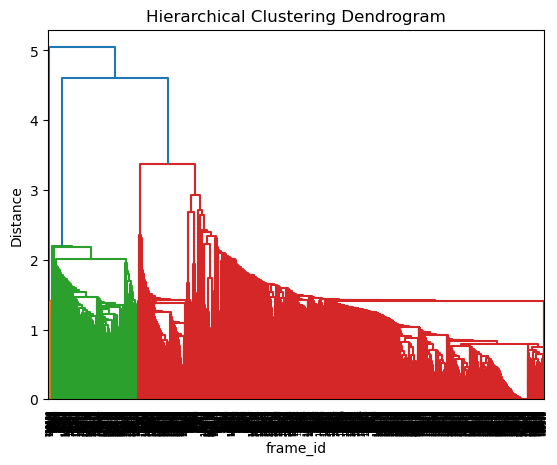

In [33]:
distance_matrx = 1 - similarity_matrix

# Perform hierarchical clustering
Z = linkage(similarity_matrix, method='average')

# Plot dendrogram
dendrogram(Z, labels=frame_ids)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('frame_id')
plt.ylabel('Distance')
plt.show()